In [1]:
import os
import pandas as pd
import numpy as np
from sqlalchemy import create_engine,text
from scipy import stats
import plotly.express as px
import toml
import psrc_theme
import geopandas as gpd
import plotly.express as px

%matplotlib inline
from IPython.display import display, HTML

# to show plotly figures in quarto HTML file
import plotly.io as pio
pio.renderers.default = "plotly_mimetype+notebook_connected"
pio.templates.default = "simple_white+psrc_color" # set plotly template

input_config = toml.load(os.path.join(os.getcwd(), '..\\..\\..\\..\\configuration', 'input_configuration.toml'))
valid_config = toml.load(os.path.join(os.getcwd(), '..\\..\\..\\..\\configuration', 'validation_configuration.toml'))

# create connection
conn = create_engine('sqlite:///../../../../inputs/db/'+input_config['db_name'])

# summary data location
csv_path = os.path.join(valid_config['model_dir'], 'outputs/validation')

# table format
pd.options.display.float_format = '{:0,.2f}'.format
format_percent = "{:,.2%}".format

## transit boarding

### boarding by mode

In [2]:
df = pd.read_csv(os.path.join(csv_path, 'daily_boardings_by_mode.csv')).sort_values('observed_boardings', ascending=False)
table_df = df.copy()

table_df.loc['Total','observed_boardings'] = table_df['observed_boardings'].sum(axis=0)
table_df.loc['Total','model_boardings'] = table_df['model_boardings'].sum(axis=0)
table_df.loc['Total','mode'] = 'Total'
table_df['diff'] = table_df['model_boardings']-table_df['observed_boardings']
table_df['perc_diff'] = table_df['diff']/table_df['observed_boardings']
table_df[['observed_boardings','model_boardings','diff']] = table_df[['observed_boardings','model_boardings','diff']].astype('float')
table_df[['perc_diff']] = table_df[['perc_diff']].applymap(format_percent)
table_df = table_df.reset_index()
table_df

,index,mode,observed_boardings,model_boardings,diff,perc_diff
0,0,b,"332,640.45","359,711.97","27,071.52",8.14%
1,4,r,"81,991.16","84,296.68","2,305.52",2.81%
2,2,f,"11,349.85","9,448.84","-1,901.01",-16.75%
3,1,c,"6,354.00","6,616.13",262.13,4.13%
4,3,p,"3,235.36","3,080.52",-154.84,-4.79%
5,Total,Total,"435,570.83","463,154.14","27,583.32",6.33%


In [3]:
df_boarding_line = pd.read_csv(os.path.join(csv_path,'daily_boardings_by_line.csv'), index_col='description')
df_boarding_line[['observed_boardings','model_boardings']] = df_boarding_line[['observed_boardings','model_boardings']].astype('float')

df_mode = df_boarding_line[df_boarding_line['route_code'].isin([6996,6999,6998])].reset_index()

df_mode['submode'] = df_mode['mode'].map({"r": "Link Red Line", "c": "Sounder"})
df_mode = df_mode[['submode','model_boardings']].copy()
df_mode = df_mode.groupby('submode')['model_boardings'].sum().reset_index()

df_obs = pd.read_sql(text("SELECT * FROM observed_transit_agency_boardings"), con=conn.connect())
df_obs_mode = df_obs.copy()
df_obs_mode['boardings'] = df_obs_mode['boardings'].astype(float)
df_obs_mode = df_obs_mode[df_obs_mode['submode'].isin(["Link","Sounder"])].copy()
df_obs_mode['submode'] = df_obs_mode['submode'].map({"Link": "Link Red Line", "Sounder": "Sounder"})

df_obs_mode = df_obs_mode.groupby(['submode','year'])['boardings'].sum().unstack().reset_index()
df_obs_mode = df_obs_mode.rename(columns={2023:'2023 boarding', 2024:'2024 boarding'})
df_mode = df_obs_mode.merge(df_mode, on='submode')

df_mode['2023 % diff'] = (df_mode['model_boardings']-df_mode['2023 boarding'])/df_mode['2023 boarding']
df_mode['2024 % diff'] = (df_mode['model_boardings']-df_mode['2024 boarding'])/df_mode['2024 boarding']
df_mode[['2023 % diff']] = df_mode[['2023 % diff']].applymap(format_percent)
df_mode[['2024 % diff']] = df_mode[['2024 % diff']].applymap(format_percent)

df_mode

,submode,2023 boarding,2024 boarding,model_boardings,2023 % diff,2024 % diff
0,Link Red Line,"78,765.00","91,203.00","80,873.68",2.68%,-11.33%
1,Sounder,"6,765.00","7,711.00","6,616.13",-2.20%,-14.20%


### boarding by agency

In [4]:
df = pd.read_csv(os.path.join(csv_path, 'daily_boardings_by_agency.csv')).sort_values('observed_boardings', ascending=False)
plot_df = df.melt(id_vars=['agency'], value_vars=['observed_boardings', 'model_boardings'],
                  var_name='source', value_name='count')

In [5]:
table_df = df.copy()

table_df.loc['Total','observed_boardings'] = table_df.sum(axis=0).observed_boardings
table_df.loc['Total','model_boardings'] = table_df.sum(axis=0).model_boardings
table_df.loc['Total','agency'] = 'Total'
table_df['diff'] = table_df['model_boardings']-table_df['observed_boardings']
table_df['perc_diff'] = table_df['diff']/table_df['observed_boardings']
table_df[['observed_boardings','model_boardings','diff']] = table_df[['observed_boardings','model_boardings','diff']].astype('float')
table_df[['perc_diff']] = table_df[['perc_diff']].applymap(format_percent)
table_df = table_df.reset_index()
table_df

,index,agency,observed_boardings,model_boardings,diff,perc_diff
0,2,King County Metro,"253,313.62","268,972.02","15,658.40",6.18%
1,5,Sound Transit,"113,374.00","130,985.30","17,611.30",15.53%
2,0,Community Transit,"25,962.00","27,417.22","1,455.22",5.61%
3,4,Pierce Transit,"21,185.00","13,686.56","-7,498.44",-35.40%
4,6,Washington Ferries,"9,278.21","5,868.09","-3,410.12",-36.75%
5,3,Kitsap Transit,"8,258.00","11,539.98","3,281.98",39.74%
6,1,Everett Transit,"4,201.00","4,668.05",467.05,11.12%
7,Total,Total,"435,571.83","463,137.23","27,565.40",6.33%


In [6]:
df = pd.read_csv(os.path.join(csv_path, 'daily_boardings_by_agency.csv'), usecols=['agency', 'model_boardings']).sort_values('model_boardings', ascending=False)
df_obs = pd.read_sql(text("SELECT * FROM observed_transit_agency_boardings"), con=conn.connect())

df_obs_agency = df_obs.copy()
df_obs_agency['boardings'] = df_obs_agency['boardings'].astype(float)
df_obs_agency = df_obs_agency.groupby(['agency','year'])['boardings'].sum().unstack().reset_index()
df_obs_agency = df_obs_agency.rename(columns={2023:'2023 boarding', 2024:'2024 boarding'})
df_agency = df_obs_agency.merge(df, on='agency')

df_agency['2023 % diff'] = (df_agency['model_boardings']-df_agency['2023 boarding'])/df_agency['2023 boarding']
df_agency['2024 % diff'] = (df_agency['model_boardings']-df_agency['2024 boarding'])/df_agency['2024 boarding']
df_agency[['2023 % diff']] = df_agency[['2023 % diff']].applymap(format_percent)
df_agency[['2024 % diff']] = df_agency[['2024 % diff']].applymap(format_percent)
df_agency = df_agency.replace('inf%', '-')

df_agency

,agency,2023 boarding,2024 boarding,model_boardings,2023 % diff,2024 % diff
0,Community Transit,"23,000.00",0.00,"27,417.22",19.21%,-
1,Everett Transit,0.00,0.00,"4,668.05",-,-
2,King County Metro,"244,306.00","272,556.00","268,972.02",10.10%,-1.31%
3,Kitsap Transit,"8,000.00","9,300.00","11,539.98",44.25%,24.09%
4,Pierce Transit,"19,974.00",0.00,"13,686.56",-31.48%,-
5,Sound Transit,"115,516.00","133,703.00","130,985.30",13.39%,-2.03%
6,Washington Ferries,0.00,0.00,"5,868.09",-,-


In [7]:
df = pd.read_csv(os.path.join(csv_path, 'daily_boardings_by_line.csv')).sort_values('observed_boardings', ascending=False)
df
df = df[df['mode'].isin(['b'])]
df = df.groupby(['agency']).sum()[['observed_boardings','model_boardings']]
df['difference'] = df['model_boardings']-df['observed_boardings']
df['percent diff'] = (df['difference']/df['observed_boardings'])
df[['percent diff']] = df[['percent diff']].applymap(format_percent)
df

# table_df.loc['Total','observed_boardings'] = table_df.sum(axis=0).observed_boardings
# table_df.loc['Total','model_boardings'] = table_df.sum(axis=0).model_boardings
# table_df.loc['Total','agency'] = 'Total'
# table_df['diff'] = table_df['model_boardings']-table_df['observed_boardings']
# table_df['perc_diff'] = table_df['diff']/table_df['observed_boardings']
# table_df[['observed_boardings','model_boardings','diff']] = table_df[['observed_boardings','model_boardings','diff']].astype('float')
# table_df[['perc_diff']] = table_df[['perc_diff']].applymap(format_percent)
# table_df = table_df.reset_index()
# table_df

,observed_boardings,model_boardings,difference,percent diff
agency,,,,
Community Transit,"25,962.00","27,417.22","1,455.22",5.61%
Everett Transit,"4,201.00","4,668.05",467.05,11.12%
King County Metro,"251,166.45","266,509.23","15,342.77",6.11%
Kitsap Transit,"4,048.00","5,671.26","1,623.26",40.10%
Pierce Transit,"21,185.00","13,686.56","-7,498.44",-35.40%
Sound Transit,"26,079.00","41,742.74","15,663.74",60.06%


### boarding by key route

In [8]:
# df_boarding_key = pd.read_csv(os.path.join(csv_path,'daily_boardings_key_routes.csv'), index_col='description')
# # df_boarding_key[['observed_boardings','model_boardings']] = df_boarding_key[['observed_boardings','model_boardings']].astype('float')
# # df = df_boarding_key[df_boarding_key['route_code'].isin([4200,4201,4203,4204,5001,5002,5003,5004,5005,5006,5007,1973,1975])].reset_index()
# # df.drop(['route_code','agency'], axis=1, inplace=True)
# # df
# df_boarding_key
df = pd.read_csv(os.path.join(csv_path, 'daily_boardings_by_line.csv'))
df = df[df['mode'].isin(['f','p'])][['description','mode','observed_boardings','model_boardings','diff','perc_diff']]
df

,description,mode,observed_boardings,model_boardings,diff,perc_diff
147,973 W Sea Water Taxi,p,759.00,450.43,-308.57,-0.41
148,975 Vashn Water Taxi,f,338.00,342.11,4.11,0.01
270,Seattle-Bremerton FF,f,"1,913.00","3,807.84","1,894.84",0.99
271,Brem-Pt Orchard FF,p,768.00,"1,085.92",317.92,0.41
272,Brem-Annapolis FF,p,469.00,244.70,-224.30,-0.48
273,Seattle-Kingston FF,p,429.00,80.00,-349.00,-0.81
274,Seattle-Southwrth FF,f,631.00,650.27,19.27,0.03
278,WSF Edmonds-Kingston,f,"1,500.13",186.49,"-1,313.64",-0.88
279,WSF Seattle-Bain Isl,f,"5,513.69","4,083.52","-1,430.17",-0.26
280,WSF Seattle-Brem,f,"1,188.97",168.89,"-1,020.08",-0.86


In [9]:
df_boarding_key = pd.read_csv(os.path.join(csv_path,'daily_boardings_key_routes.csv'), index_col='description')
df_boarding_key[['observed_boardings','model_boardings']] = df_boarding_key[['observed_boardings','model_boardings']].astype('float')

df = df_boarding_key[df_boarding_key['route_code'].isin([4200,4201,4203,4204,5001,5002,5003,5004,5005,5006,5007,1973,1975])].reset_index()
df.drop(['route_code','agency'], axis=1, inplace=True)

df_table = df.copy()
df_table[['perc_diff']] = df_table[['perc_diff']].applymap(format_percent)
df_table

,description,observed_boardings,model_boardings,diff,perc_diff


In [10]:
if len(df) > 0:
    ax = df.plot(kind='scatter', x='observed_boardings', y='model_boardings')
    lim = df[['observed_boardings','model_boardings']].max().max()*1.05
    ax.set_ylim(0,lim)
    ax.set_xlim(0,lim)
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, x)
    slope, intercept, r_value, p_value, std_err = stats.linregress(df['observed_boardings'],df['model_boardings'])
    print('r^2 ' + str('') + ': ' + str(r_value))

In [11]:
# df = pd.read_csv(os.path.join(csv_path,'bike_ferry_boardings.csv')).sort_values('@bvol', ascending=False)
# df['route_code'] = df['route_code'].astype('int')
# df[['route_code','description', '@bvol']]

In [12]:
df = df_boarding_key[df_boarding_key['route_code'].isin([6996,6999,6998])].reset_index()
df['description'] = df['route_code'].map({6998: 'Sounder South', 6999: 'Sounder North',6996: 'Link Red Line'})
df.drop(['route_code','agency'], axis=1, inplace=True)

df_table = df.copy()
df_table[['perc_diff']] = df_table[['perc_diff']].applymap(format_percent)

df_table

,description,observed_boardings,model_boardings,diff,perc_diff
0,Sounder South,"6,038.00","6,612.92",574.92,9.52%
1,Sounder North,316.00,3.20,-312.80,-98.99%


r^2 : 1.0


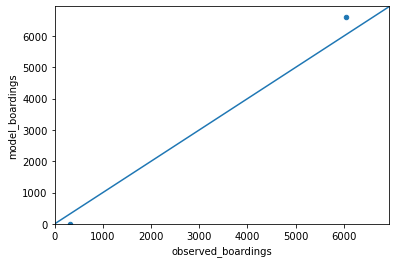

In [13]:
if len(df) > 0:
    ax = df.plot(kind='scatter', x='observed_boardings', y='model_boardings')
    lim = df[['observed_boardings','model_boardings']].max().max()*1.05
    ax.set_ylim(0,lim)
    ax.set_xlim(0,lim)
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, x)
    slope, intercept, r_value, p_value, std_err = stats.linregress(df['observed_boardings'],df['model_boardings'])
    print('r^2 ' + str('') + ': ' + str(r_value))

In [14]:
df = df_boarding_key[df_boarding_key['route_code'].isin([1671,1672,1673,1674,1675,1676,6550,1007,1040,1997,1998])].reset_index()
df['description'] = df['route_code'].map({1671: 'A Line RapidRide', 1672: 'B Line RapidRide',
                                            1673: 'C Line RapidRide', 1674: 'D Line RapidRide',
                                            1675: 'E Line RapidRide', 1676: 'F Line RapidRide',
                                            6550: 'Sound Transit 550', 1040: 'KC Metro 40', 1007: 'KC Metro 7',
                                            1997: 'SLU Streetcar', 1998: 'First Hill Streetcar'})
df.drop(['route_code','agency'], axis=1, inplace=True)

df_table = df.copy()
df_table[['perc_diff']] = df_table[['perc_diff']].applymap(format_percent)
df_table.sort_values('model_boardings', ascending=False)

,description,observed_boardings,model_boardings,diff,perc_diff
4,E Line RapidRide,"11,426.00","14,503.27","3,077.27",26.93%
2,C Line RapidRide,"7,250.00","10,296.22","3,046.22",42.02%
3,D Line RapidRide,"9,044.00","7,308.10","-1,735.90",-19.19%
0,A Line RapidRide,"8,412.00","6,680.45","-1,731.55",-20.58%
1,B Line RapidRide,"4,177.00","3,199.95",-977.05,-23.39%


r^2 : 0.8331120022525144


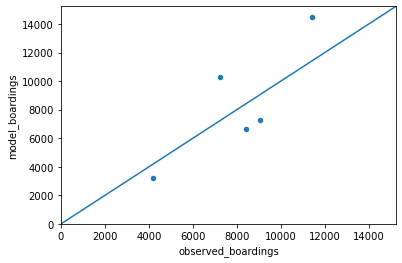

In [15]:
if len(df) > 0:
    ax = df.plot(kind='scatter', x='observed_boardings', y='model_boardings')
    lim = df[['observed_boardings', 'model_boardings']].max().max() * 1.05
    ax.set_ylim(0, lim)
    ax.set_xlim(0, lim)
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, x)
    slope, intercept, r_value, p_value, std_err = stats.linregress(df['observed_boardings'], df['model_boardings'])
    print('r^2 ' + str('') + ': ' + str(r_value))

### Top routes by agency

In [16]:
df = pd.read_csv(os.path.join(csv_path, 'daily_boardings_by_line.csv'))
# df_top = pd.DataFrame()
# for agency in df['agency'].unique():
#     _df = df[df['agency'] == agency].sort_values('model_boardings', ascending=False).head(8)
#     df_top = pd.concat([df_top, _df])
# df = df_top[['agency','description','mode','model_boardings','observed_boardings','diff','perc_diff']]
cols=['agency','description','mode','model_boardings','observed_boardings','diff','perc_diff']

In [17]:
agency = 'King County Metro'
df[df['agency'] == agency].sort_values('model_boardings', ascending=False).head(10)[cols]

,agency,description,mode,model_boardings,observed_boardings,diff,perc_diff
130,King County Metro,E-Line,b,"14,503.27","11,426.00","3,077.27",0.27
5,King County Metro,7 Rain Bch-ColC-CBD,b,"11,000.59","9,954.00","1,046.59",0.11
128,King County Metro,C Line,b,"10,296.22","7,250.00","3,046.22",0.42
28,King County Metro,40 Ngt-Bal-Fre-CBD,b,"8,373.93","7,208.00","1,165.93",0.16
129,King County Metro,D Line,b,"7,308.10","9,044.00","-1,735.90",-0.19
132,King County Metro,H-Line,b,"7,146.36","6,907.00",239.36,0.03
126,King County Metro,A Line,b,"6,680.45","8,412.00","-1,731.55",-0.21
67,King County Metro,160 Aub-Kent-Rent,b,"6,455.08","5,058.00","1,397.08",0.28
43,King County Metro,70 Udst-Elake-CBD,b,"6,059.07","4,189.00","1,870.07",0.45
39,King County Metro,62 SndPt-GLk-Fre-CBD,b,"6,041.85","5,899.00",142.85,0.02


In [18]:
agency = 'Sound Transit'
df[df['agency'] == agency].sort_values('model_boardings', ascending=False).head(10)[cols]

,agency,description,mode,model_boardings,observed_boardings,diff,perc_diff
309,Sound Transit,Light Rail Ang Lk-NG,r,"80,873.68","79,522.00","1,351.68",0.02
293,Sound Transit,550 Bellevue-Seattle,b,"7,072.45","3,351.00","3,721.45",1.11
310,Sound Transit,Commutr Rail Tac-Sea,c,"6,612.92","6,038.00",574.92,0.10
286,Sound Transit,512 Everett-Northgte,b,"5,112.20","2,251.00","2,861.20",1.27
292,Sound Transit,545 Redmond-Seattle,b,"4,769.67","3,340.00","1,429.67",0.43
288,Sound Transit,522 Woodinvl-Roosvlt,b,"4,759.20","1,736.00","3,023.20",1.74
294,Sound Transit,554 Issaquah-Seattle,b,"4,219.08","2,153.00","2,066.08",0.96
300,Sound Transit,578 Seattle-Puyallup,b,"2,864.40","1,460.00","1,404.40",0.96
298,Sound Transit,574 Lakewood-SeaTac,b,"2,167.06","1,848.00",319.06,0.17
296,Sound Transit,560 W Sea-Bellevue,b,"2,078.36","1,227.00",851.36,0.69


In [19]:
agency = 'Community Transit'
df[df['agency'] == agency].sort_values('model_boardings', ascending=False).head(10)[cols]

,agency,description,mode,model_boardings,observed_boardings,diff,perc_diff
230,Community Transit,Swift Blue,b,"6,083.98","3,804.00","2,279.98",0.60
231,Community Transit,Swift Green,b,"2,540.28","3,000.00",-459.72,-0.15
200,Community Transit,116 Edm-Silver Firs,b,"2,182.78",955.00,"1,227.78",1.29
199,Community Transit,115 McClm P&R-AurVil,b,"1,686.82","1,133.00",553.82,0.49
205,Community Transit,201 Smokey Pt-Lynnwd,b,"1,487.14","1,049.00",438.14,0.42
206,Community Transit,202 Smokey Pt-Lynnwd,b,"1,480.71","1,002.00",478.71,0.48
191,Community Transit,101 Mar P&R-Aur Vill,b,"1,398.01",945.00,453.01,0.48
198,Community Transit,113 Mukilteo-Lynn TC,b,868.30,802.00,66.30,0.08
203,Community Transit,130 Edmonds-Lynnwood,b,851.18,618.00,233.18,0.38
216,Community Transit,280 Gran Falls-Evrt,b,728.74,335.00,393.74,1.18


In [20]:
agency = 'Pierce Transit'
df[df['agency'] == agency].sort_values('model_boardings', ascending=False).head(10)[cols]

,agency,description,mode,model_boardings,observed_boardings,diff,perc_diff
160,Pierce Transit,1 6th Ave-Pac Ave,b,"1,557.02","3,035.00","-1,477.98",-0.49
161,Pierce Transit,2 S 19th-Bridgeport,b,"1,105.92","1,729.00",-623.08,-0.36
185,Pierce Transit,402 Meridian,b,"1,049.95",626.00,423.95,0.68
184,Pierce Transit,400 Puyllp-Tacoma,b,931.97,336.00,595.97,1.77
189,Pierce Transit,500 Federal Way,b,877.09,845.00,32.09,0.04
162,Pierce Transit,3 Lakewood-Tacoma,b,874.76,"1,250.00",-375.24,-0.30
190,Pierce Transit,501 Miltn-Fed Way,b,806.85,431.00,375.85,0.87
163,Pierce Transit,4 Lakewd-South Hill,b,658.99,968.00,-309.01,-0.32
169,Pierce Transit,41 S 56th St-Salish,b,644.60,"1,088.00",-443.40,-0.41
172,Pierce Transit,48 Sheridan-M St,b,506.03,"1,065.00",-558.97,-0.52


In [21]:
agency = 'Kitsap Transit'
df[df['agency'] == agency].sort_values('model_boardings', ascending=False).head(10)[cols]

,agency,description,mode,model_boardings,observed_boardings,diff,perc_diff
270,Kitsap Transit,Seattle-Bremerton FF,f,"3,807.84","1,913.00","1,894.84",0.99
271,Kitsap Transit,Brem-Pt Orchard FF,p,"1,085.92",768.00,317.92,0.41
244,Kitsap Transit,217 Brem-Silverdle E,b,915.50,417.00,498.50,1.20
242,Kitsap Transit,212 Brem-Silverdle W,b,707.45,679.00,28.45,0.04
274,Kitsap Transit,Seattle-Southwrth FF,f,650.27,631.00,19.27,0.03
259,Kitsap Transit,86 Southwrth Shuttle,b,615.75,91.00,524.75,5.77
260,Kitsap Transit,390 Poulsbo-Bainbrdg,b,472.78,170.00,302.78,1.78
243,Kitsap Transit,215 McWilliams,b,274.73,115.00,159.73,1.39
272,Kitsap Transit,Brem-Annapolis FF,p,244.70,469.00,-224.30,-0.48
254,Kitsap Transit,333 Silvrdale-Bainb,b,242.13,114.00,128.13,1.12


In [22]:
agency = 'Everett Transit'
df[df['agency'] == agency].sort_values('model_boardings', ascending=False).head(10)[cols]

,agency,description,mode,model_boardings,observed_boardings,diff,perc_diff
316,Everett Transit,7 Coll Stn-Mall Stn,b,"2,565.62","2,239.00",326.62,0.15
320,Everett Transit,29 Coll Stn-Mall Stn,b,"1,274.87",881.00,393.87,0.45
313,Everett Transit,3 Seaway TC-Evt Stn,b,329.78,285.00,44.78,0.16
317,Everett Transit,8 Airport Rd-Evt Stn,b,107.40,156.00,-48.60,-0.31
312,Everett Transit,2 Marnr P&R-Mall Stn,b,97.37,148.00,-50.63,-0.34
315,Everett Transit,6 Waterfront-Evt Stn,b,88.35,62.00,26.35,0.42
319,Everett Transit,18 Mukilteo-Evt Stn,b,71.91,60.00,11.91,0.20
314,Everett Transit,4 Evt Stn-Collge Stn,b,69.04,114.00,-44.96,-0.39
318,Everett Transit,12 Mall Stn-Seawy TC,b,63.71,256.00,-192.29,-0.75


### boarding on lines by agency

r^2 Community Transit: 0.9007795816325459
r^2 Everett Transit: 0.989536030359279
r^2 King County Metro: 0.9474693992296992
r^2 Kitsap Transit: 0.9309984200053502
r^2 Pierce Transit: 0.743026959451729


r^2 Sound Transit: 0.9974394214193536
r^2 Washington Ferries: 0.9431540455365335


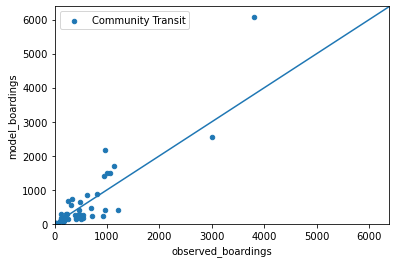

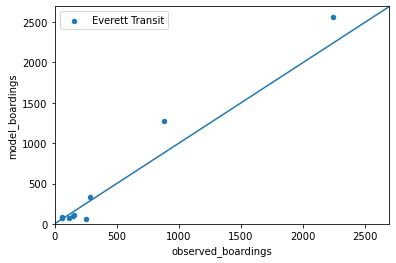

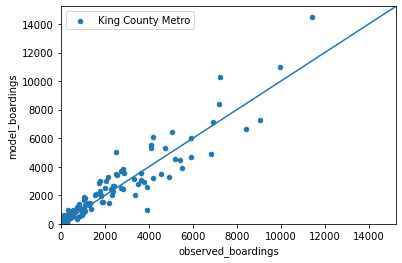

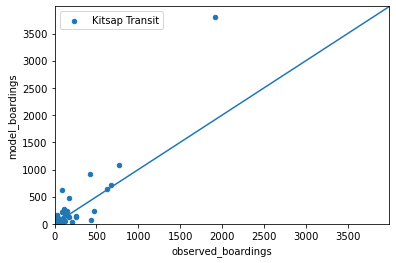

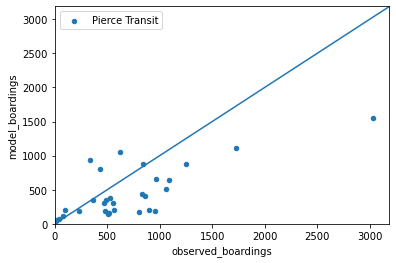

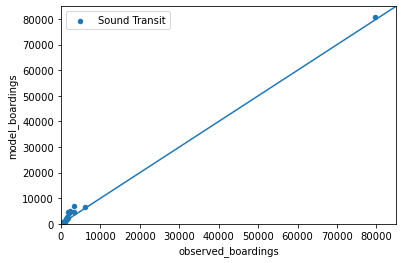

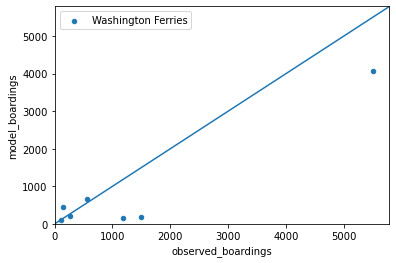

In [23]:
df = pd.read_csv(os.path.join(csv_path,'daily_boardings_by_line.csv'), index_col='agency')
df = df[-df['agency_id'].isnull()]

for agency in np.unique(df.index):
    _df = df.loc[agency,:]
    if (type(_df) == pd.core.frame.DataFrame) & (len(df) > 0):
        ax = _df.plot(kind='scatter', x='observed_boardings', y='model_boardings', label=agency)
        lim = _df[['observed_boardings','model_boardings']].max().max()*1.05
        ax.set_ylim(0,lim)
        ax.set_xlim(0,lim)
        x = np.linspace(*ax.get_xlim())
        ax.plot(x, x)
        slope, intercept, r_value, p_value, std_err = stats.linregress(_df['observed_boardings'],_df['model_boardings'])
        print('r^2 ' + str(agency) + ': ' + str(r_value))

### boarding by light rail station

In [24]:
df = pd.read_csv(os.path.join(csv_path,'light_rail_boardings.csv'), index_col='station_name')
df['diff'] = df['model_boardings']-df['observed_boardings']
df['percent_diff'] = df['diff']/df['observed_boardings']

df_table = df.copy()
df_table[['percent_diff']] = df_table[['percent_diff']].applymap(format_percent)
df_table

,observed_boardings,model_boardings,diff,percent_diff
station_name,,,,
Husky Stadium,"4,821.00","3,516.48","-1,304.52",-27.06%
Westlake,"9,739.00","10,399.49",660.49,6.78%
Symphony,"4,263.00","6,244.96","1,981.96",46.49%
Pioneer Square,"2,664.00","5,265.95","2,601.95",97.67%
Int'l District,"4,797.00","1,901.84","-2,895.16",-60.35%
Capitol Hill,"7,263.00","7,520.59",257.59,3.55%
Stadium,"2,320.00",281.21,"-2,038.79",-87.88%
SODO,"1,652.00","2,346.76",694.76,42.06%
Beacon Hill,"2,211.00","1,460.40",-750.60,-33.95%


In [25]:
df_combined = df.copy()

df_combined['station_group'] = df.index
df_combined.loc[['Westlake'],'station_group'] = 'Westlake/Symphony'
df_combined.loc[['Symphony'],'station_group'] = 'Westlake/Symphony'

df_combined.loc[['Pioneer Square'],'station_group'] = "Pioneer Square/Int'l District"
df_combined.loc[["Int'l District"],'station_group'] = "Pioneer Square/Int'l District"

df_combined.loc[['Stadium'],'station_group'] = 'Stadium/SODO'
df_combined.loc[['SODO'],'station_group'] = 'Stadium/SODO'

df_combined.loc[['Beacon Hill'],'station_group'] = 'Beacon Hill/Mount Baker'
df_combined.loc[['Mount Baker'],'station_group'] = 'Beacon Hill/Mount Baker'

df_combined.loc[['Othello'],'station_group'] = 'Othello/Rainier Beach'
df_combined.loc[['Rainier Beach'],'station_group'] = 'Othello/Rainier Beach'

df_combined = df_combined.groupby('station_group').sum()[['observed_boardings','model_boardings']]
df_combined['diff'] = df_combined['model_boardings']-df_combined['observed_boardings']
df_combined['percent_diff'] = df_combined['diff']/df_combined['observed_boardings']
df_combined[['percent_diff']] = df_combined[['percent_diff']].applymap(format_percent)

df_combined.loc[['Husky Stadium','Capitol Hill','Westlake/Symphony',"Pioneer Square/Int'l District",
                 'Stadium/SODO','Beacon Hill/Mount Baker','Columbia City','Othello/Rainier Beach',
                 "Tukwila Int'l Blvd",'SeaTac/Airport','Angle Lake']]

,observed_boardings,model_boardings,diff,percent_diff
station_group,,,,
Husky Stadium,"4,821.00","3,516.48","-1,304.52",-27.06%
Capitol Hill,"7,263.00","7,520.59",257.59,3.55%
Westlake/Symphony,"14,002.00","16,644.45","2,642.45",18.87%
Pioneer Square/Int'l District,"7,461.00","7,167.79",-293.21,-3.93%
Stadium/SODO,"3,972.00","2,627.96","-1,344.04",-33.84%
Beacon Hill/Mount Baker,"4,269.00","3,267.53","-1,001.47",-23.46%
Columbia City,"1,840.00","1,786.63",-53.37,-2.90%
Othello/Rainier Beach,"3,486.00","3,771.66",285.66,8.19%
Tukwila Int'l Blvd,"2,423.00","2,771.47",348.47,14.38%


In [26]:
df_obs = pd.read_sql(
    "SELECT * FROM light_rail_station_boardings WHERE year IN (2023, 2024)",
    con=conn,
)
df_obs.rename(columns={"boardings": "observed_boardings"}, inplace=True)

# df_obs.groupby(['year','station_name']).sum()
df_obs = pd.pivot_table(df_obs, values='observed_boardings', columns='year', index='station_name', aggfunc=np.sum)
df_obs = df_obs.fillna(0)
df_obs

df = pd.read_csv(os.path.join(csv_path,'light_rail_boardings.csv'), index_col='station_name', usecols=['station_name','model_boardings'])
df = df.merge(df_obs,  left_index=True, right_index=True, how='outer')
df = df[df.index != 'Total']
df = df[~df['model_boardings'].isnull()]
df

,model_boardings,2023,2024
station_name,,,
Angle Lake,"2,604.38","3,840.00","5,093.00"
Beacon Hill,"1,460.40","2,211.00","2,672.00"
Capitol Hill,"7,520.59","7,263.00","8,207.00"
Columbia City,"1,786.63","1,840.00","2,145.00"
Husky Stadium,"3,516.48","4,821.00","5,122.00"
Int'l District,"1,901.84","4,797.00","5,372.00"
Mount Baker,"1,807.13","2,058.00","2,458.00"
Northgate Station,"7,958.28","10,430.00","4,150.00"
Othello,"2,164.62","2,083.00","2,466.00"


## light rail stop transfers

In [27]:
df = pd.read_csv(os.path.join(csv_path,'light_rail_transfers.csv'), index_col='station_name')
df[['percent_diff']] = df[['percent_diff']].applymap(format_percent)
df

,modeled_transfer_rate,observed_transfer_rate,diff,percent_diff
station_name,,,,
Husky Stadium,0.82,-99.00,99.82,-100.83%
Westlake,0.12,0.36,-0.25,-67.75%
Symphony,0.29,0.20,0.09,44.50%
Pioneer Square,0.37,0.16,0.22,135.66%
Int'l District,0.52,0.45,0.07,16.23%
Capitol Hill,0.06,-99.00,99.06,-100.06%
Stadium,0.36,0.12,0.24,199.36%
SODO,0.65,0.31,0.34,108.13%
Beacon Hill,0.33,0.35,-0.02,-5.42%


## Park and Ride

In [28]:
df = pd.read_csv(r'C:\Workspace\sc_2023_01_30_25\outputs\daysim\_trip.tsv', sep='\t')
pnr_boardings = df[(df['otaz'].isin(range(3750,4001))) & (df['mode']==6)]
pnr_boardings = pnr_boardings.groupby('otaz').count()[['trexpfac']].reset_index()

In [29]:
stations = [
    {"id": 3751, "name": "Tukwila Station (CR)"},
    {"id": 3752, "name": "Tacoma Dome Station"},
    {"id": 3753, "name": "South Tacoma (CR)"},
    {"id": 3754, "name": "Everett Station (CR)"},
    {"id": 3755, "name": "Sumner Station (CR)"},
    {"id": 3756, "name": "Mukilteo Station"},
    {"id": 3757, "name": "Kent Station (CR)"},
    {"id": 3758, "name": "Auburn Station (CR)"},
    {"id": 3759, "name": "Lakewood (CR)"},
    {"id": 3760, "name": "Gateway P&R"},
    {"id": 3761, "name": "Puyallup Station (SB)"},
    {"id": 3762, "name": "Twin Lakes P&R"},
    {"id": 3763, "name": "Crossroads Neighborhood Church"},
    {"id": 3764, "name": "Overlake Transit Center"},
    {"id": 3765, "name": "Redondo Heights P&R"},
    {"id": 3766, "name": "North Gig Harbor/Kimball Drive"},
    {"id": 3767, "name": "Duvall P&R"},
    {"id": 3768, "name": "Roy 'Y' P&R"},
    {"id": 3769, "name": "South Hill (Elim Evangelical)"},
    {"id": 3770, "name": "Parkland Transit Center"},
    {"id": 3771, "name": "SR-512/I-5 (Lakewood)"},
    {"id": 3772, "name": "Center Street P&R"},
    {"id": 3773, "name": "Tacoma Mall Transit Center"},
    {"id": 3774, "name": "South Tacoma West"},
    {"id": 3775, "name": "South Tacoma East - 2"},
    {"id": 3776, "name": "Narrows P&R"},
    {"id": 3777, "name": "North Purdy/Purdy Crescent"},
    {"id": 3778, "name": "Point Defiance Ferry"},
    {"id": 3779, "name": "South Federal P&R"},
    {"id": 3780, "name": "Sultan P&R"},
    {"id": 3781, "name": "Federal Way P&R (320th)"},
    {"id": 3782, "name": "Auburn P&R"},
    {"id": 3783, "name": "Star Lake P&R"},
    {"id": 3784, "name": "Holy Spirit Lutheran Church"},
    {"id": 3785, "name": "Kent/Des Moines P&R"},
    {"id": 3786, "name": "Kent/James St. P&R"},
    {"id": 3787, "name": "Burien Transit Center"},
    {"id": 3788, "name": "Tukwila"},
    {"id": 3789, "name": "Maple Valley P&R"},
    {"id": 3790, "name": "South Renton P&R"},
    {"id": 3791, "name": "Renton Highlands P&R (St. Matts)"},
    {"id": 3792, "name": "Issaquah Transit Center"},
    {"id": 3793, "name": "Mercer Island P&R"},
    {"id": 3794, "name": "Mercer Island Presbyterian"},
    {"id": 3795, "name": "Newport Hills P&R"},
    {"id": 3796, "name": "Newport Hills Community Church"},
    {"id": 3797, "name": "Newport Covenant Church"},
    {"id": 3798, "name": "South Bellevue P&R"},
    {"id": 3799, "name": "Wilburton"},
    {"id": 3800, "name": "Eastgate P&R"},
    {"id": 3801, "name": "North Bend P&R"},
    {"id": 3802, "name": "Evergreen Point P&R"},
    {"id": 3803, "name": "Grace Lutheran Church"},
    {"id": 3804, "name": "South Kirkland P&R"},
    {"id": 3805, "name": "Overlake P&R"},
    {"id": 3806, "name": "Houghton P&R"},
    {"id": 3807, "name": "Bethel Lutheran"},
    {"id": 3808, "name": "Redmond P&R"},
    {"id": 3809, "name": "Saint Thomas Episcopal"},
    {"id": 3810, "name": "Valley Center"},
    {"id": 3811, "name": "Bear Creek P&R"},
    {"id": 3812, "name": "Kingsgate P&R"},
    {"id": 3813, "name": "Brickyard P&R"},
    {"id": 3814, "name": "Northshore P&R"},
    {"id": 3815, "name": "Kenmore P&R"},
    {"id": 3816, "name": "Bethany Bible Church"},
    {"id": 3817, "name": "Bothell P&R"},
    {"id": 3818, "name": "Woodinville P&R"},
    {"id": 3819, "name": "Olson & Meyers"},
    {"id": 3820, "name": "Spokane Street P&R"},
    {"id": 3821, "name": "Greenlake P&R"},
    {"id": 3822, "name": "Northgate TC"},
    {"id": 3823, "name": "North Jackson Park"},
    {"id": 3824, "name": "Shoreline"},
    {"id": 3825, "name": "112th St. & I-5"},
    {"id": 3826, "name": "Ober Park"},
    {"id": 3827, "name": "Vashon Heights"},
    {"id": 3828, "name": "Mountlake Terrace P&R"},
    {"id": 3829, "name": "Bethesda Lutheran"},
    {"id": 3830, "name": "Edmonds Station"},
    {"id": 3831, "name": "Edmonds P&R"},
    {"id": 3832, "name": "Lynnwood P&R"},
    {"id": 3833, "name": "Swamp Creek P&R"},
    {"id": 3834, "name": "Mariner P&R"},
    {"id": 3835, "name": "Snohomish"},
    {"id": 3836, "name": "Marysville - Ash Ave"},
    {"id": 3837, "name": "116th & I-5 - Marysville"},
    {"id": 3838, "name": "SR-531 - Marysville"},
    {"id": 3839, "name": "Arlington P&R"},
    {"id": 3840, "name": "Stanwood"},
    {"id": 3841, "name": "Monroe"},
    {"id": 3842, "name": "Federal Way"},
    {"id": 3843, "name": "Port Orchard Armory"},
    {"id": 3844, "name": "Southworth Ferry P&R"},
    {"id": 3845, "name": "McWilliams P&R"},
    {"id": 3846, "name": "Bethany Lutheran Church"},
    {"id": 3847, "name": "Gateway Fellowship"},
    {"id": 3848, "name": "Agate Pass P&R/Clearwater"},
    {"id": 3849, "name": "Kingston Ferry P&R"},
    {"id": 3850, "name": "Suquamish United Church of Christ"},
    {"id": 3851, "name": "Bainbridge Island Ferry"},
    {"id": 3852, "name": "Puyallup Station (NB)"},
    {"id": 3853, "name": "72nd Street Transit Center"},
    {"id": 3855, "name": "DuPont"},
    {"id": 3856, "name": "Aurora Village TC"},
    {"id": 3857, "name": "Aurora Nazarene"},
    {"id": 3858, "name": "Saint Margaret's Episcopal"},
    {"id": 3861, "name": "Lake Meridian P&R"},
    {"id": 3862, "name": "Smokey Pt. Church"},
    {"id": 3863, "name": "Eastmont P&R"},
    {"id": 3864, "name": "McCollum Park P&R"},
    {"id": 3865, "name": "Canyon Park P&R"},
    {"id": 3866, "name": "Korean Presby. P&R"},
    {"id": 3867, "name": "Georges Kountry Korner"},
    {"id": 3868, "name": "Poulsbo Church of the Nazarene"},
    {"id": 3870, "name": "Harper Evangelical Free Church"},
    {"id": 3871, "name": "Mullenix Road"},
    {"id": 3873, "name": "TCC P&R"},
    {"id": 3874, "name": "Ash Way P&R"},
    {"id": 3875, "name": "Bonney Lake P&R"},
    {"id": 3876, "name": "Tukwila Int. Station"},
    {"id": 3877, "name": "South Hill P&R"},
    {"id": 3878, "name": "South Tacoma East - 1"},
    {"id": 3879, "name": "Issaquah Highlands"},
    {"id": 3880, "name": "Lake Stevens TC"},
    {"id": 3881, "name": "Liberty Bay Presbyterian"},
    {"id": 3882, "name": "NK Baptist"},
    {"id": 3883, "name": "Preston P&R"},
    {"id": 3884, "name": "Bayside Community Church"},
    {"id": 3885, "name": "Ollala Valley Fire Station"},
    {"id": 3886, "name": "Bremerton Ferry"},
    {"id": 3888, "name": "Puyallup Fair's Red Lot"},
    {"id": 3889, "name": "Marysville - Cedar & Grove"},
    {"id": 3890, "name": "Stanwood II"},
    {"id": 3891, "name": "Marysville I P&R"},
    {"id": 3892, "name": "Martha Lake Covenant Church"},
    {"id": 3893, "name": "South Sammammish P&R"},
    {"id": 3894, "name": "Renton City Municipal Garage"},
    {"id": 3895, "name": "Tibbetts Lot"},
    {"id": 3896, "name": "Renton Transit Center"},
    {"id": 3897, "name": "Calvary Christian Assembly"},
    {"id": 3898, "name": "Maple Valley Town Square"},
    {"id": 3899, "name": "All Saints Lutheran Church"},
    {"id": 3900, "name": "City View Church"},
    {"id": 3901, "name": "Northwest University 6710 Bldg."},
    {"id": 3902, "name": "Sammamish Lutheran P&R"},
    {"id": 3903, "name": "Redmond Ridge P&R"},
    {"id": 3904, "name": "Kennydale United Methodist Church"},
    {"id": 3905, "name": "Nativity Lutheran Church"},
    {"id": 3906, "name": "South Jackson P&R"},
    {"id": 3907, "name": "South SeaTac (LR)"},
    {"id": 3908, "name": "Everett Station"},
    {"id": 3909, "name": "Bremerton (SR-303/Riddell Road)"},
    {"id": 3910, "name": "Silverdale"},
    {"id": 3911, "name": "Tukwila Station (CR)"},
    {"id": 3913, "name": "Sumner Station Garage"},
    {"id": 3914, "name": "Tacoma Dome"},
    {"id": 3915, "name": "Bothell (SR-527/185th Street)"},
    {"id": 3916, "name": "SR-3/SR-303"},
    {"id": 3917, "name": "SR-16/SR-160"},
    {"id": 3918, "name": "I-5 & 175th"}
]

In [30]:
pnr_capacity = pd.read_csv(r'C:\Workspace\sc_2023_01_30_25\inputs\scenario\networks\p_r_nodes.csv')
df = pnr_capacity.merge(pnr_boardings, left_on='ZoneID', right_on='otaz')
df.rename(columns={'ZoneID': 'taz', 'trexpfac': 'Model Boardings'}, inplace=True)
df['Boardings/Capacity'] = df['Model Boardings']/df['Capacity']
df.head()

,NodeID,taz,XCoord,YCoord,Capacity,Cost,otaz,Model Boardings,Boardings/Capacity
0,3719,3751,"1,292,102.12","170,904.47",390,0,3751,134,0.34
1,3720,3752,"1,244,894.82","91,851.41",2337,0,3752,230,0.10
2,3721,3753,"1,229,573.94","78,529.59",220,0,3753,8,0.04
3,3722,3754,"1,306,255.47","358,805.35",1107,0,3754,86,0.08
4,3723,3755,"1,289,549.88","76,554.53",350,0,3755,245,0.70


In [31]:
df_station_names = pd.DataFrame(stations)
df = df.merge(df_station_names, how='left', left_on='taz', right_on='id')

In [32]:
# df

In [33]:
df['color'] = np.where(df['Boardings/Capacity'] > 1, 'Boardings/Capacity > 1', 'Boardings/Capacity <= 1')

fig = px.scatter(df, y='Model Boardings', x='Capacity', title='Model Boardings vs Capacity',
                 hover_data={'name': True, 'Model Boardings': True, 'Capacity': True, 'Boardings/Capacity': ':.2f'},
                 color='color')
fig.update_layout(height=600, width=800)
fig.show()

In [34]:


gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.XCoord, df.YCoord), crs='EPSG:2285')
gdf.to_crs('EPSG:4326', inplace=True)



In [35]:

fig = px.scatter_mapbox(gdf, lat=gdf.geometry.y, lon=gdf.geometry.x, color='Boardings/Capacity', 
                        size='Boardings/Capacity', hover_data=['taz','Model Boardings', 'Capacity'], 
                        title='Park and Ride Usage vs Capacity', zoom=7)
fig.update_layout(mapbox_style="carto-positron")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

fig.show()